## Thinking Glasses On

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

In [3]:
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

In [4]:
methods = ['VG', 'COW', 'LNAM']
for eddy in the_frontier_eddies:
    for t in range(30):
        for method in methods:
            df = frontier_sample_data[eddy]['T'+str(t)][method]
            # Drop Li 2022 measurement of tilt
            if 'TD' in list(df.columns):
                df = df.drop(columns=['TD'])
            # Centralise at surface center 
            df['x'] = df['x'] - df.iloc[0]['x']
            df['y'] = df['y'] - df.iloc[0]['y']
            # Interpolate to equidistant z-layers
            DEPTH_INT = 10
            new_depth = np.arange(0, -z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1], DEPTH_INT)
            interp_x = interp1d(-df['Depth'], df['x'], kind='linear', fill_value="extrapolate")
            interp_y = interp1d(-df['Depth'], df['y'], kind='linear', fill_value="extrapolate")
            df = pd.DataFrame({
                "x": interp_x(new_depth),
                "y": interp_y(new_depth),
                "Depth": -new_depth
            })
            df['TD'] = np.hypot(df['x'], df['y'])
            frontier_sample_data[eddy]['T'+str(t)][method] = df


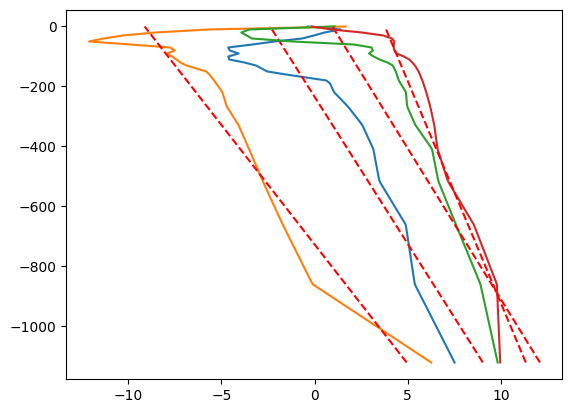

In [5]:
eddy = the_frontier_eddies[2]
method = 'VG'
nob = 0
for t in range(nob, nob+4):
    df = frontier_sample_data[eddy]['T'+str(t)][method]
    
    x = df['x']/1000
    y = df['Depth']

    slope, intercept = np.polyfit(x, y, 1) 
    y_min, y_max = y.min(), y.max()
    x_min = (y_min - intercept) / slope
    x_max = (y_max - intercept) / slope
    fit_x = np.array([x_min, x_max])
    fit_y = slope * fit_x + intercept
    plt.plot(x, y)  
 
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    if r_squared >=.1:
        plt.plot(fit_x, fit_y, color='red', linestyle='--')
    
        

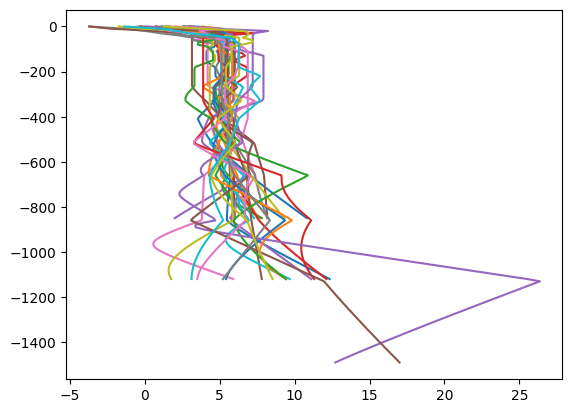

In [6]:
eddy = the_frontier_eddies[0]
method = 'COW'

x1 = frontier_sample_data[eddy]['T0'][method]['TD']/1000 
z1 = frontier_sample_data[eddy]['T0'][method]['Depth']

df_best_shift = pd.DataFrame({'T0': [0, 0]}, index=['i', 'rmse'])
T = 20
# for t in range(T, T+10):
xs, zs = [], []
for t in range(30):
    x2 = frontier_sample_data[eddy]['T'+str(t)][method]['TD']/1000
    z2 = frontier_sample_data[eddy]['T'+str(t)][method]['Depth']
    
    df = pd.DataFrame(columns=['i', 'rmse'])
    for i in np.arange(-30, 31, .2):
        x2_shifted = x2 + i
        rmse = np.sqrt(((x1 - x2_shifted) ** 2).mean())
        df.loc[len(df)] = {'i': i, 'rmse': rmse}
    
    i_min_rmse = df.loc[df['rmse'] == df['rmse'].min(), 'i'].iloc[0]
    min_rmse = df['rmse'].min()

    df_best_shift['T'+str(t)] = [i_min_rmse, min_rmse]

    # if min_rmse < 3:
    # plt.plot(x2 + i_min_rmse, z2)
    plt.plot(x2 + i_min_rmse, z2)
    xs.extend(x2 + i_min_rmse)
    zs.extend(z2)
xs = np.array(xs) - np.min(xs)

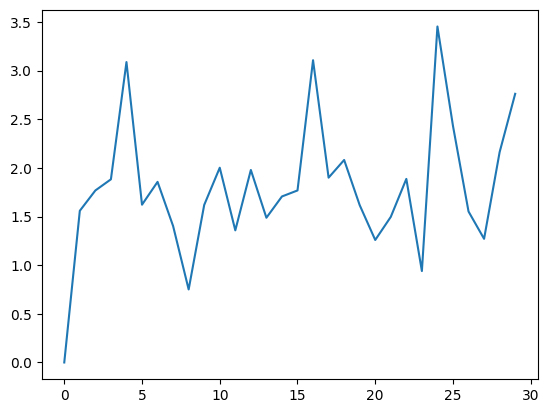

In [7]:
plt.plot(range(30), df_best_shift.loc['rmse'])

In [8]:
df_best_shift

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
i,-1.065814e-13,-0.200000,2.600000,2.60000,-1.200000,-0.20000,1.000000,-4.200000,-0.400000,2.40000,...,2.400000,1.600000,1.200000,2.400000,1.800000,-1.200000,2.000000,0.400000,0.40000,-3.200000
rmse,1.065814e-13,1.558961,1.767822,1.88246,3.087519,1.62155,1.856164,1.402044,0.750591,1.61898,...,1.258922,1.496566,1.886598,0.939664,3.453158,2.430946,1.551683,1.270836,2.16179,2.761142


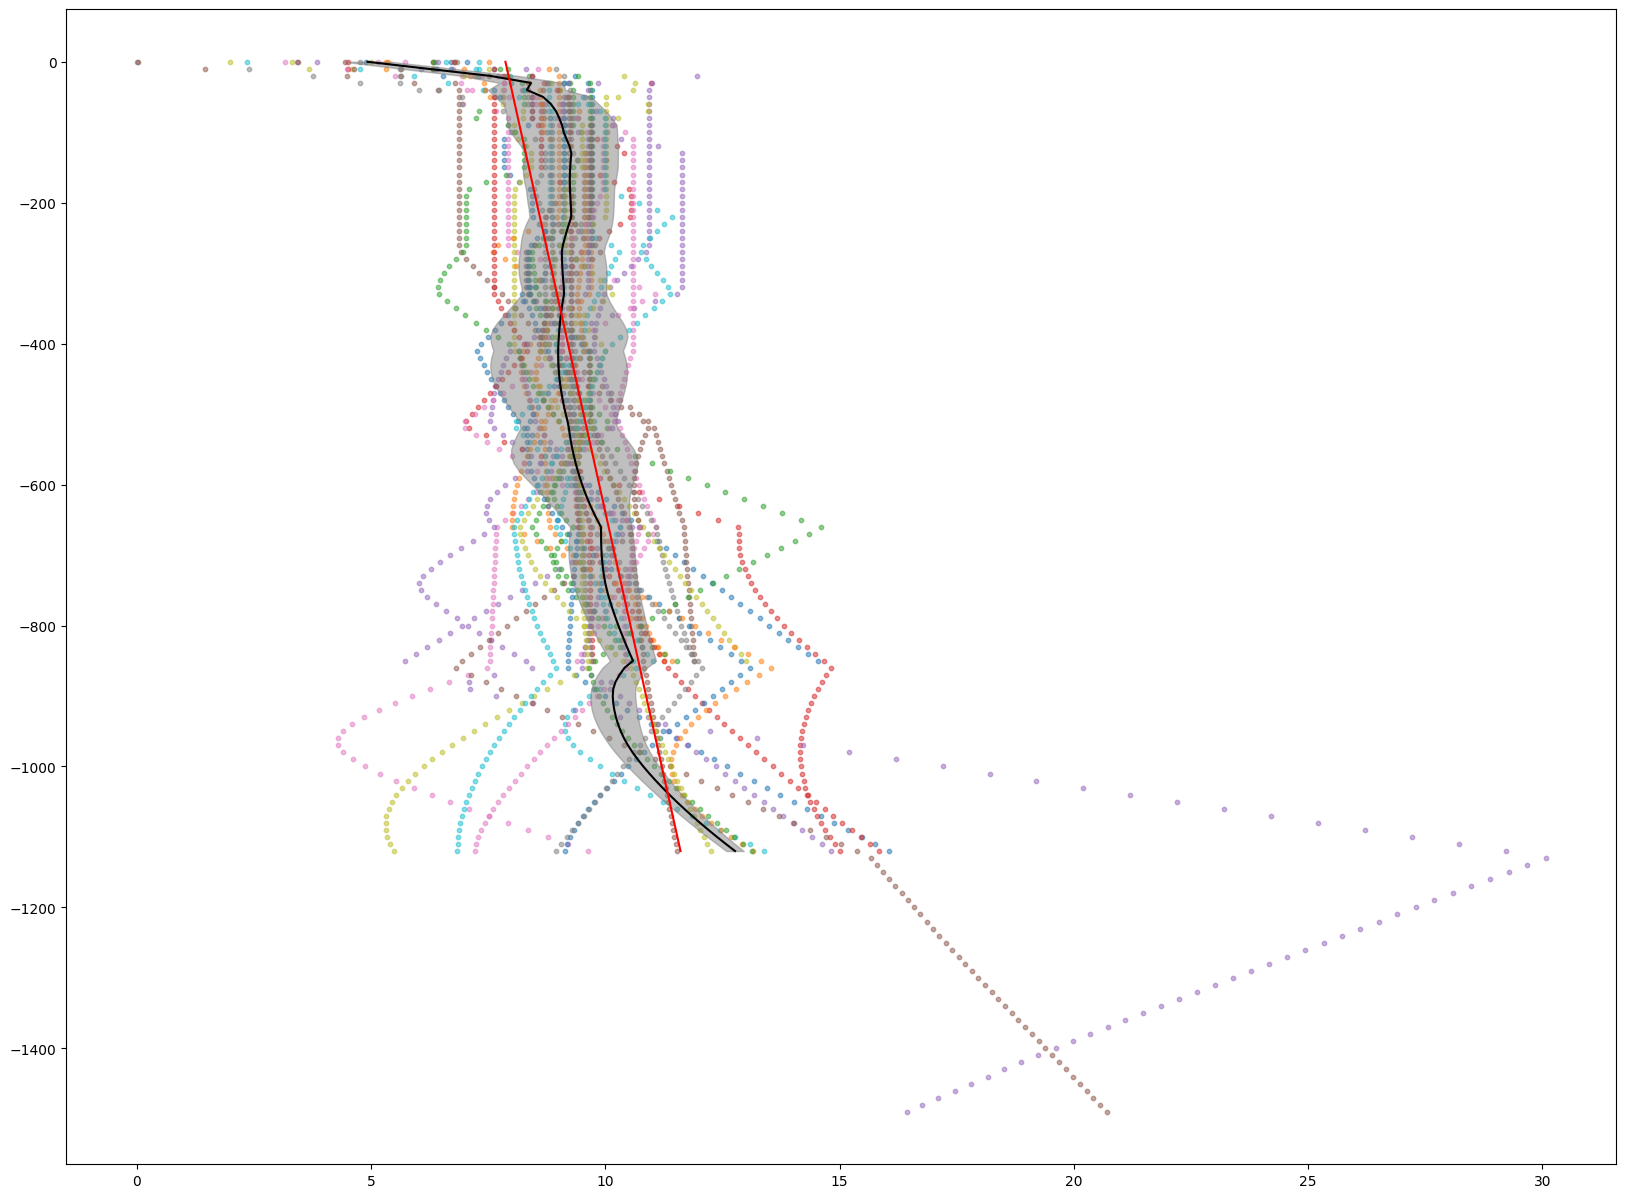

In [9]:
xmin = 0
for t in range(30):
    i = df_best_shift.loc['i']['T'+str(t)]
    xmin = min(np.nanmin(frontier_sample_data[eddy]['T'+str(t)][method]['TD'])/1000 + i, xmin)
plt.figure(figsize=(20,15))
for t in range(30):
    i = df_best_shift.loc['i']['T'+str(t)]
    plt.scatter(frontier_sample_data[eddy]['T'+str(t)][method]['TD']/1000 + i - xmin, frontier_sample_data[eddy]['T'+str(t)][method]['Depth'], alpha=.5, s=10)

DATA_THRESH = 5

# MEAN
df_mean = pd.DataFrame({'x':xs, 'z': zs})
# df_mean = df_mean.groupby('z')['x'].mean().reset_index()
df_mean = df_mean.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
df_mean = df_mean.groupby('z')['x'].mean().reset_index()
plt.plot(df_mean['x'], df_mean['z'], 'k')

# STD
df_std = pd.DataFrame({'x':xs, 'z': zs})
# df_std = df_std.groupby('z')['x'].std().reset_index()
df_std = df_std.groupby('z').filter(lambda group: len(group) >= DATA_THRESH)
df_std = df_std.groupby('z')['x'].std().reset_index()
# for x, z, w in zip(df_mean['x'], df_mean['z'], 1 /df_std['x']):
#     plt.plot([x-w, x+w], [z, z], 'k', linewidth=1)
plt.fill_betweenx(df_mean['z'], 
                  df_mean['x'] - 1 / df_std['x'], 
                  df_mean['x'] + 1 / df_std['x'], 
                  color='gray', alpha=0.5)

# Linear Regression
x = df_mean['x']
z = df_mean['z']
w = 1 / df_std['x']

m, b = np.polyfit(x, z, 1, w=w)
z_min, z_max = z.min(), z.max()
x_min = (z_min - b) / m
x_max = (z_max - b) / m
x_fit = np.array([x_min, x_max])
z_fit = m * x_fit + b
plt.plot(x_fit, z_fit, color='red')

